
```
conda create -n tf_env python=3.10 pip -y
conda activate tf_env
pip install tensorflow==2.17.1 keras==3.5.0 numpy==1.26.4 scipy==1.13.1 seaborn==0.13.2 tensorflow-model-optimization==0.8.0 scikit-plot==0.3.7 tf_keras==2.17.0
python3 -m pip install tensorflow[and-cuda]
```

In [1]:
# ! pip install tensorflow-model-optimization

Imports

In [2]:
import tensorflow as tf
import numpy as np
import scipy
import os
from tensorflow_model_optimization.python.core.keras.compat import keras
import time 

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")



2024-11-24 20:49:24.052215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 20:49:24.064264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 20:49:24.067524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 20:49:24.076755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 20:49:24.666816: W tensorflow/compiler/tf2

TensorFlow version: 2.17.1
NumPy version: 1.26.4
SciPy version: 1.11.4


In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU está conectada")
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        print(f"Nome da GPU: {gpu.name}")
else:
    print("Não conectado a uma GPU")

GPU está conectada
Nome da GPU: /physical_device:GPU:0


I0000 00:00:1732492165.444660  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732492165.464077  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732492165.466685  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Funções auxiliares

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
#import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import interp

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        # skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        # plt.savefig("ks_plot.png")
        # plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

Definindo paths e carregabdo os dados

In [5]:
path = "/home/pedro/projetoDL/dataset/processado/"
save_path = "/home/pedro/projetoDL/log/prunning/fold3/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Carregar os dados
Y = np.load(path + 'Y_train_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_train_NewApproach_Injected_v2.npz')
X = X.f.arr_0

Selecionar os dados do fold 3 (Melhor resultado)

In [6]:
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import KFold
import numpy as np
import os

# Configurar o KFold e selecionar o fold 3
skf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 0

for train_index, val_index in skf.split(X, Y):
    fold_no += 1
    if fold_no == 3:  # Selecionar o fold 3
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = Y[train_index], Y[val_index]
        break



# Verificar os dados
print(f"Tamanho de x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Tamanho de x_val: {x_val.shape}, y_val: {y_val.shape}")
print("Distribuição em y_train:", np.unique(y_train, return_counts=True))
print("Distribuição em y_val:", np.unique(y_val, return_counts=True))

Tamanho de x_train: (514647, 44, 116), y_train: (514647,)
Tamanho de x_val: (128662, 44, 116), y_val: (128662,)
Distribuição em y_train: (array([0, 1]), array([134480, 380167]))
Distribuição em y_val: (array([0, 1]), array([33964, 94698]))


In [7]:
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
warnings.simplefilter("ignore")



Treinar o modelo sem prunning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 116, 32)       832       
                                                                 
 batch_normalization (Batch  (None, 44, 116, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 58, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 22, 58, 64)        256       
 chNormalization)                                                
                                                        

I0000 00:00:1732492168.557460  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732492168.560262  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732492168.562706  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732492168.673404  144971 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

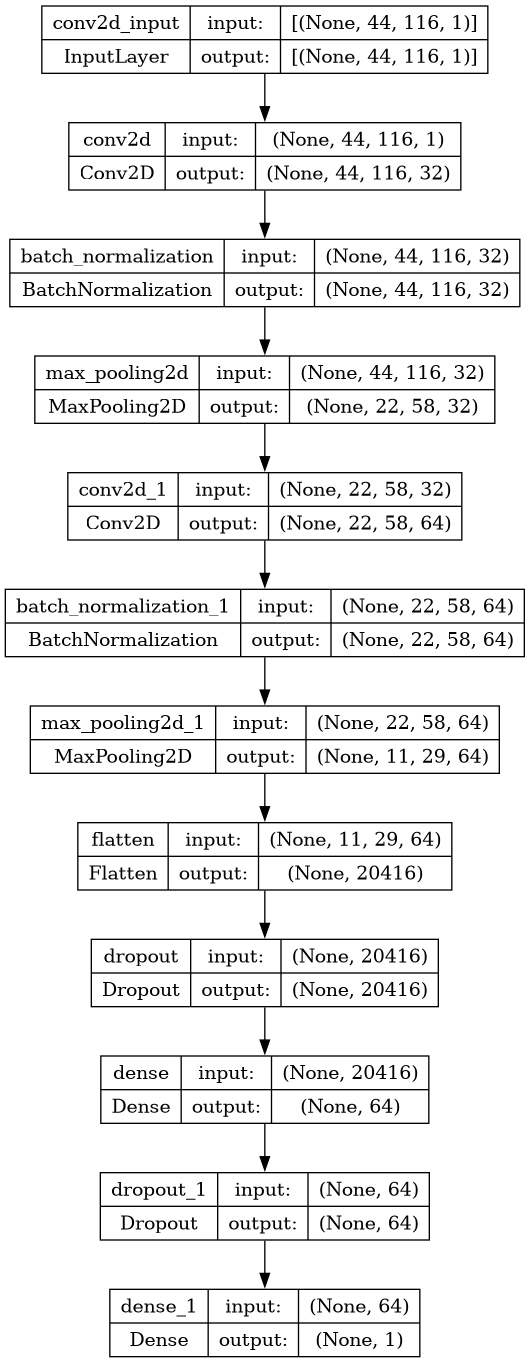

Epoch 1/10


2024-11-24 20:49:31.078846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1732492171.133359  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.152933  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.167741  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.181541  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.186321  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.190565  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.195527  145119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492171.209211  145119 gpu_t

2009/2011 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.9058

W0000 00:00:1732492246.627758  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.629663  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.630581  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.632238  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.633856  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.635986  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.637076  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.642364  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492246.645030  145121 gp

2011/2011 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.9059

W0000 00:00:1732492247.057136  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.060169  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.063016  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.064682  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.069839  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.074743  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.077471  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.081835  145118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492247.084715  145118 gp

2011/2011 [==============================] - 83s 40ms/step - loss: 0.3496 - accuracy: 0.9059 - val_loss: 0.4059 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/10
   1/2011 [..............................] - ETA: 1:13 - loss: 0.1065 - accuracy: 0.9961

W0000 00:00:1732492253.882145  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.885608  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.886731  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.889151  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.891466  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.894375  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.895790  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.904978  145117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492253.907336  145117 gp

2011/2011 [==============================] - 79s 39ms/step - loss: 0.0651 - accuracy: 0.9953 - val_loss: 0.0395 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 3/10
2011/2011 [==============================] - 79s 39ms/step - loss: 0.0322 - accuracy: 0.9971 - val_loss: 0.0282 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 4/10
2011/2011 [==============================] - 79s 39ms/step - loss: 0.0266 - accuracy: 0.9975 - val_loss: 0.0234 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 5/10
2011/2011 [==============================] - 70s 35ms/step - loss: 0.0222 - accuracy: 0.9977 - val_loss: 0.0159 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 6/10
2011/2011 [==============================] - 69s 34ms/step - loss: 0.0201 - accuracy: 0.9978 - val_loss: 0.0279 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 7/10
2011/2011 [==============================] - 69s 34ms/step - loss: 0.0188 - accuracy: 0.9979 - val_loss: 0.0195 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 8/10
2011/2011 [==============================] - 6

In [8]:
from tensorflow_model_optimization.python.core.keras.compat import keras
from PIL import Image

# Configurar o mixed precision
# Equivalent to the two lines above
keras.mixed_precision.set_global_policy('float32')

# Definir o modelo Sequential
model = keras.Sequential([
    # 1ª camada convolucional
    keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01), padding='same', input_shape=(44, 116, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 2ª camada convolucional
    keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.01), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Camada de Flatten para transformar os dados em vetor
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),

    # Camadas densas (fully connected)
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid', dtype='float32')  # Saída para classificação binária
])

# Mostrar resumo do modelo
print(model.summary())

# Gerar visualização do modelo
keras.utils.plot_model(model, to_file="conv2d.png", show_shapes=True, show_layer_names=True)
display(Image.open('conv2d.png'))

# Compilando o modelo
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Callbacks
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Treinando o modelo
batch_size = 256
history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
    verbose=1,
    shuffle=True
)


In [9]:
model_save_path = save_path + "full/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


keras_file = model_save_path + 'fold3_only.h5'
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved full baseline model to:', keras_file)

Saved full baseline model to: /home/pedro/projetoDL/log/prunning/fold3/full/fold3_only.h5


Avaliar o desempenho e salvar o modelo pra uso posterior

  94/4021 [..............................] - ETA: 6s

W0000 00:00:1732492906.218143  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.219310  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.220115  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.221194  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.222255  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.223314  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.224167  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.226400  145122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492906.227460  145122 gp

4021/4021 [==============================] - 7s 2ms/step


W0000 00:00:1732492912.873030  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.874088  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.874865  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.875839  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.876798  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.877750  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.878559  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.880338  145121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732492912.881298  145121 gp

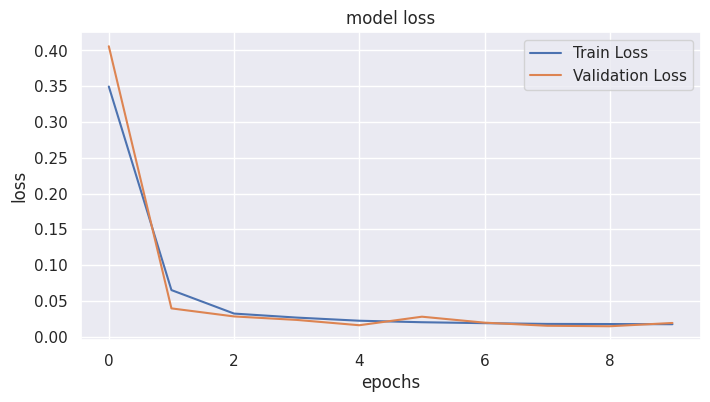

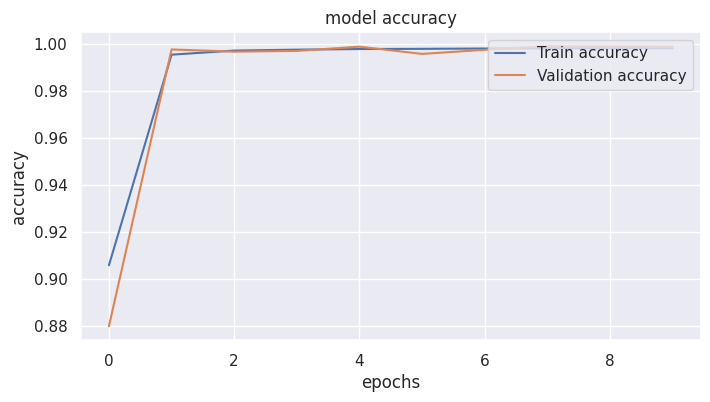

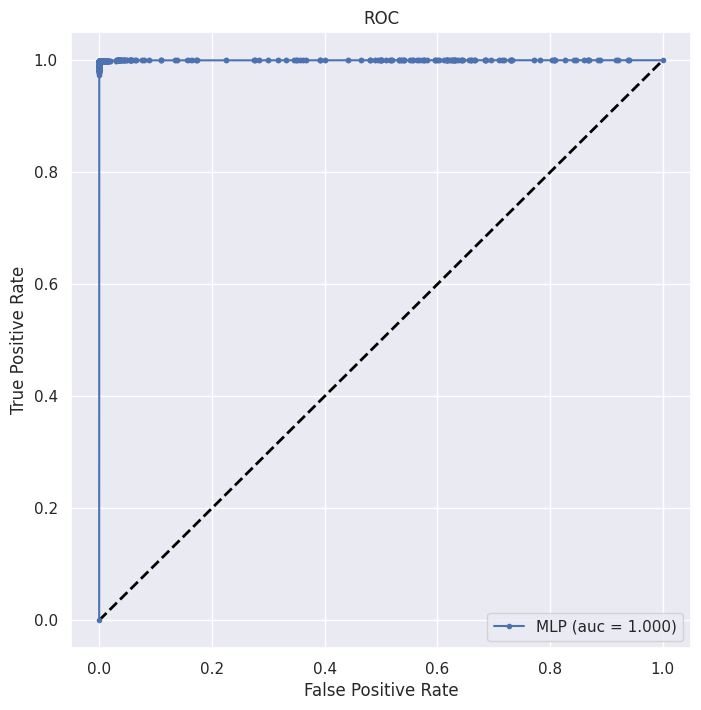

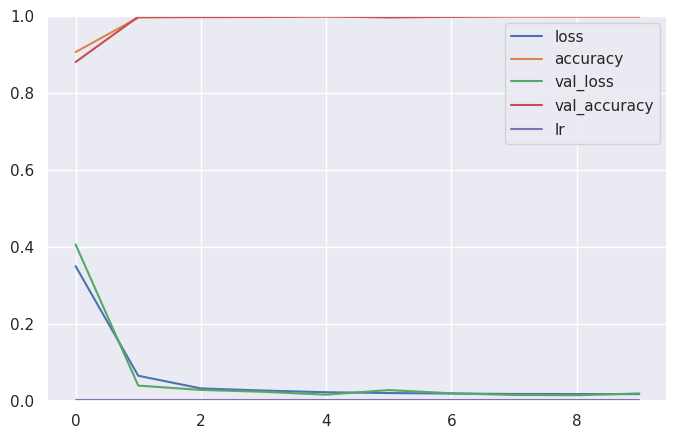

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# import scikitplot as skplt

file_name = f'log_modelo_fold3.txt'
file1 = open(os.path.join(model_save_path, file_name), "a")

start = time.time()
y_pred_scores = model.predict(x_val)
end = time.time()

print(f"Runtime of the program is {end - start}", file=file1)
total_time = end - start
timesample = total_time/y_pred_scores.shape[0]
print(f"us/sample is {timesample*1000000}", file=file1)

y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)

mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for full model: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_save_path + "loss_and_val_loss.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_save_path + "loss_and_val_accuracy.png")
plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(model_save_path + "plot_roc.png")
plt.show()
#########################################################################################################
#Plotando o histórico do treino
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

file1.close()


Fine-tune pre-trained model with prunning

In [11]:
import tensorflow_model_optimization as tfmot
import numpy as np

# Pruning: Reduzir a magnitude de pesos irrelevantes no modelo
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Definir parâmetros de pruning
batch_size = 256
epochs = 2
validation_split = 0.1  # Usar 10% do conjunto de treinamento para validação

# Calcular o número de passos para finalizar o pruning após 2 épocas
num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Definir parâmetros de pruning
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,  # Começar com 50% de pesos zerados
        final_sparsity=0.80,    # Finalizar com 80% de pesos zerados
        begin_step=0,
        end_step=end_step
    )
}

# Criar o modelo com pruning
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Recompilar o modelo
model_for_pruning.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',  # Manter a função de perda consistente
    metrics=["accuracy"]
)

# Mostrar o resumo do modelo
model_for_pruning.summary()

# Ajustar callbacks para incluir pruning
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Treinar o modelo com pruning
history_pruning = model_for_pruning.fit(
    x_train, y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 44, 116, 32)       1634      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, 44, 116, 32)       129       
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_po  (None, 22, 58, 32)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 22, 58, 64)        102466    
 _1 (PruneLowMagnitude)                                 

In [12]:
model_prunned_save_path = save_path + "prunned/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(model_prunned_save_path):
    os.makedirs(model_prunned_save_path)


keras_file = model_save_path + 'prunned.h5'
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved prunned baseline model to:', keras_file)

Saved prunned baseline model to: /home/pedro/projetoDL/log/prunning/fold3/full/prunned.h5


# Evaluate prunned model

4021/4021 [==============================] - 7s 2ms/step


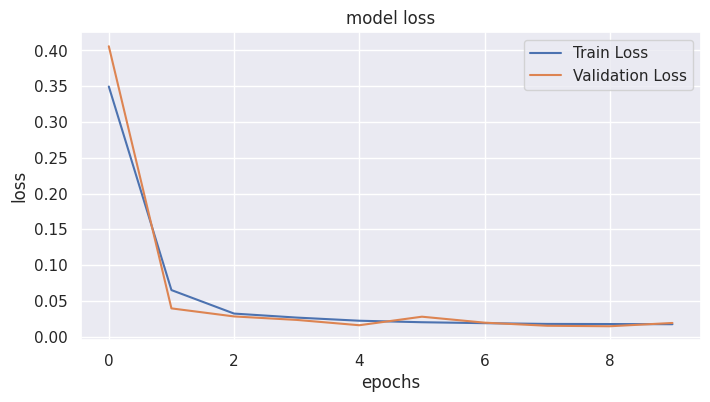

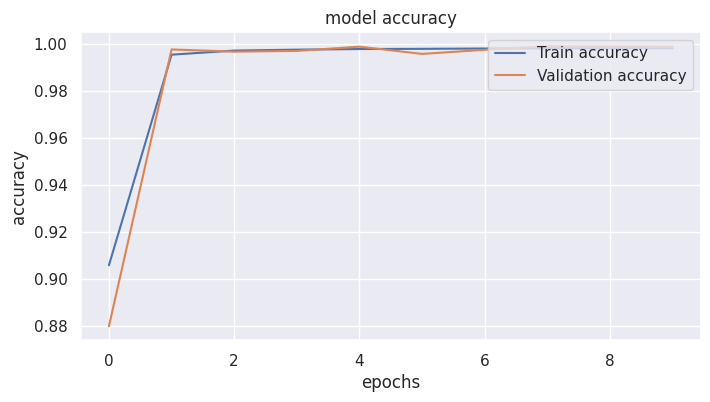

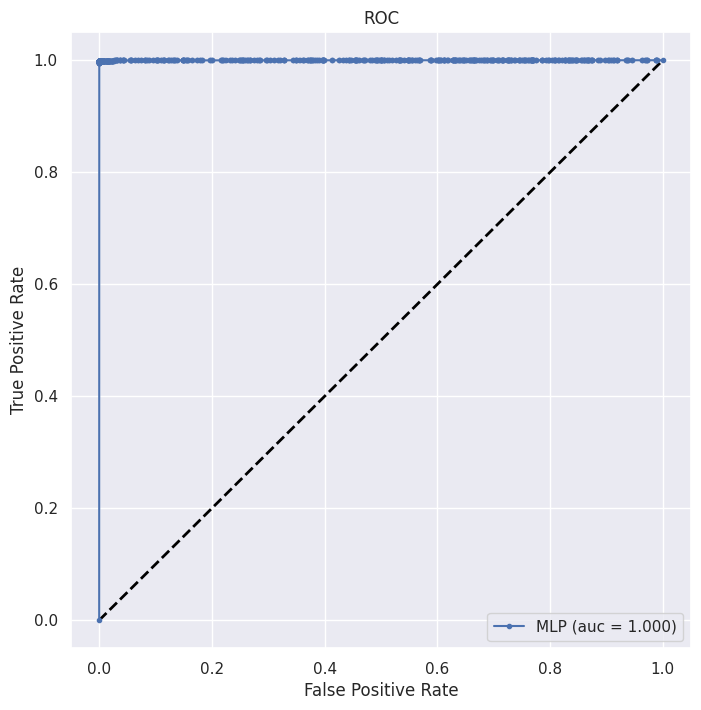

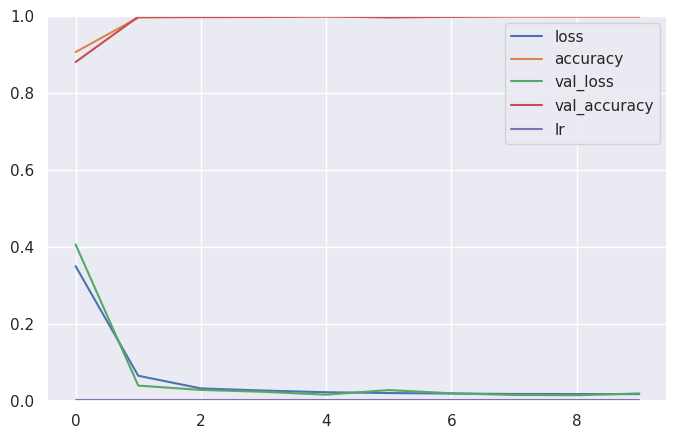

In [13]:
file_name = f'log_modelo_fold3.txt'
file1 = open(os.path.join(model_prunned_save_path, file_name), "a")

start = time.time()
y_pred_scores = model_for_pruning.predict(x_val)
end = time.time()

print(f"Runtime of the program is {end - start}", file=file1)
total_time = end - start
timesample = total_time/y_pred_scores.shape[0]
print(f"us/sample is {timesample*1000000}", file=file1)

y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for Prunned Model [50% sparsity (50% zeros in weights) and end with 80% sparsity]:\n Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_prunned_save_path + "loss_and_val_loss_prunned.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_prunned_save_path + "loss_and_val_accuracy_prunned.png")
plt.show()

# sns.set(rc={'figure.figsize':(8,8)})
# subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
# subplot.set_ylim(-0.5, 1.5)
# plt.savefig(save_path + "conf_matrix.png")
# plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(model_prunned_save_path + "plot_roc_prunned.png")
plt.show()
#########################################################################################################
#Plotando o histórico do treino
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

file1.close()

Create a 3x smaller models from pruning

In [14]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

model_3xprunned_save_path = save_path + "prunned/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(model_prunned_save_path):
    os.makedirs(model_prunned_save_path)

pruned_keras_file = model_3xprunned_save_path + '3xPrunned.h5'
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /home/pedro/projetoDL/log/prunning/fold3/prunned/3xPrunned.h5


In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = model_3xprunned_save_path + 'TFLite_3xPrunned.tflite'

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /home/pedro/projetoDL/log/prunning/fold3/prunned/TFLite_3xPrunned.tflite


W0000 00:00:1732493070.896987  144971 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732493070.896998  144971 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-24 21:04:30.897179: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwajv2ifw
2024-11-24 21:04:30.898192: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-24 21:04:30.898201: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpwajv2ifw
2024-11-24 21:04:30.901967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-24 21:04:30.902786: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-24 21:04:30.920941: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpwajv2ifw
2024-11-24 21:04:30.927119: I tensorflow/cc/saved_model/loader.cc

In [16]:
import tempfile

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  zipped_file = model_3xprunned_save_path + '3xPrunned.zip'
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [17]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 1616700.00 bytes
Size of gzipped pruned Keras model: 1616710.00 bytes
Size of gzipped pruned TFlite model: 1553863.00 bytes


Create a 10x smaller model

In [ ]:
model_10xprunned_save_path = save_path + "10xPrunned/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(model_10xprunned_save_path):
    os.makedirs(model_10xprunned_save_path)


converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

quantized_and_pruned_tflite_file = model_10xprunned_save_path + "10xPrunned_TFLite.tflite"

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

W0000 00:00:1732493072.306051  144971 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732493072.306061  144971 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-24 21:04:32.306166: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp04ixiu7z
2024-11-24 21:04:32.307271: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-24 21:04:32.307279: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp04ixiu7z
2024-11-24 21:04:32.312341: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-24 21:04:32.331797: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp04ixiu7z
2024-11-24 21:04:32.338169: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 32004 microseconds.


Saved quantized and pruned TFLite model to: /home/pedro/projetoDL/log/prunning/fold3/10xPrunned/10xPrunned_TFLite.tflite
Size of gzipped baseline Keras model: 1616700.00 bytes
Size of gzipped pruned and quantized TFlite model: 410106.00 bytes


# Evaluate 10x smaller model

4021/4021 [==============================] - 7s 2ms/step


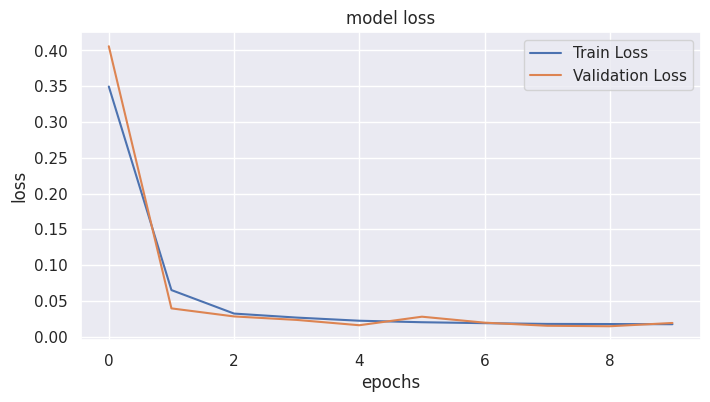

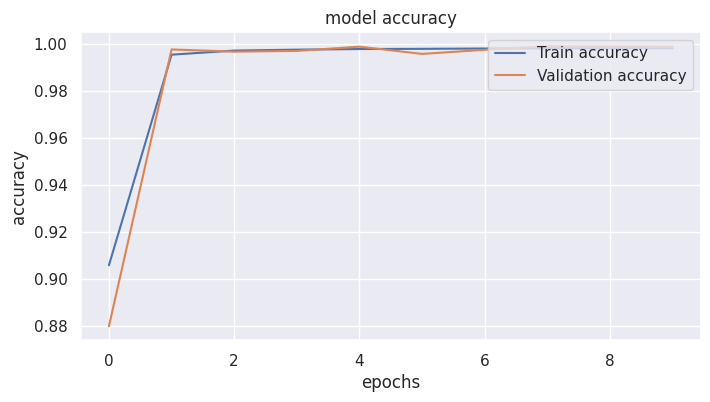

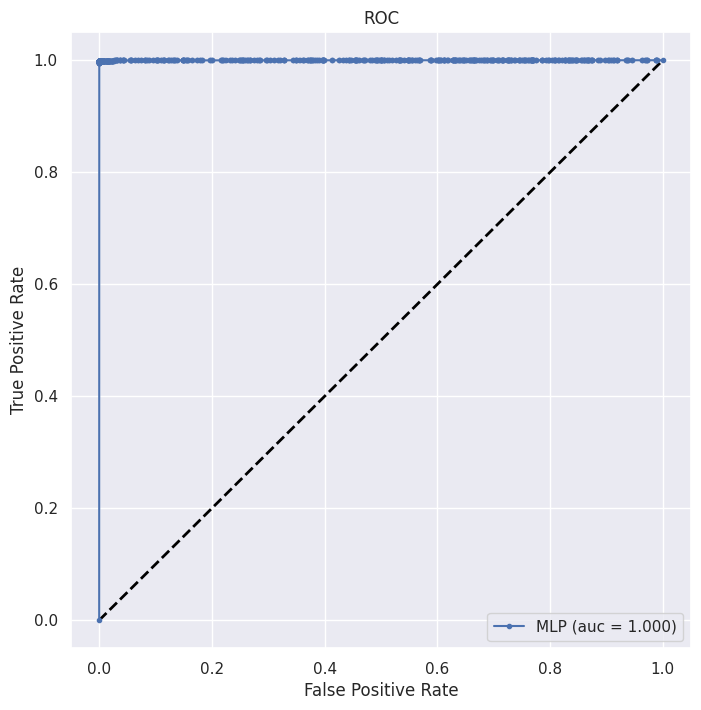

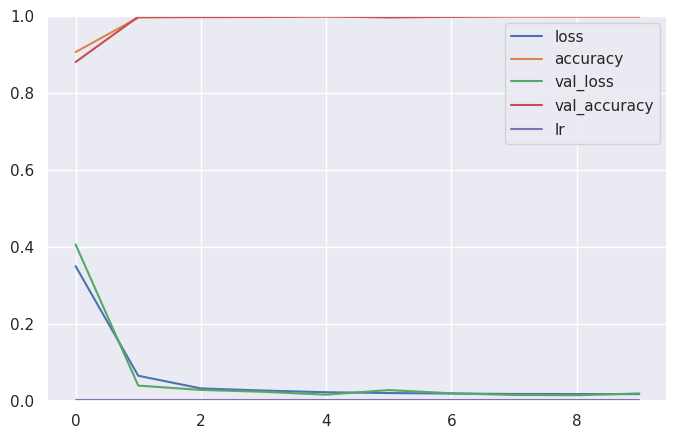

In [19]:
file_name = f'log_modelo_fold3.txt'
file1 = open(os.path.join(model_10xprunned_save_path, file_name), "a")

start = time.time()
y_pred_scores = model.predict(x_val)
end = time.time()

print(f"Runtime of the program is {end - start}", file=file1)
total_time = end - start
timesample = total_time/y_pred_scores.shape[0]
print(f"us/sample is {timesample*1000000}", file=file1)

y_pred_class = (y_pred_scores > 0.5).astype("int64")

y_pred_scores2 = y_pred_scores
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)


mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for Prunned Model [10x]:\n Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_10xprunned_save_path + "loss_and_val_loss_prunned.png")
plt.show()

sns.set(rc={'figure.figsize':(8,8)})
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(model_10xprunned_save_path + "loss_and_val_accuracy_prunned.png")
plt.show()

# sns.set(rc={'figure.figsize':(8,8)})
# subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
# subplot.set_ylim(-0.5, 1.5)
# plt.savefig(save_path + "conf_matrix.png")
# plt.show()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
auc_keras = auc(fpr_keras, tpr_keras)


sns.set(rc={'figure.figsize':(8,8)})
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig(model_10xprunned_save_path + "plot_roc_prunned.png")
plt.show()
#########################################################################################################
#Plotando o histórico do treino
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

file1.close()

# Create a more optimized model

In [25]:
# Adicionar a dimensão de canais aos dados de treinamento e validação
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

# Confirmar as novas formas dos dados
print("Forma de x_train:", x_train.shape)  # Deve ser (n_samples, 44, 116, 1)
print("Forma de x_val:", x_val.shape)      # Deve ser (n_samples, 44, 116, 1)

# **1. Strip Pruning wrappers from the model to prepare for export**
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# **2. Aplicar a quantização totalmente inteira ao modelo podado**

# Defina o caminho para salvar o modelo otimizado
optimized_model_save_path = save_path + "Optimized_Prunned_Quantized_Model/"

# Verifica se o diretório existe, se não, cria o diretório
if not os.path.exists(optimized_model_save_path):
    os.makedirs(optimized_model_save_path)

def representative_data_gen():
    for input_value in x_val:
        # input_value já tem a forma (44, 116, 1)
        # Adicionar a dimensão de batch
        input_value = np.expand_dims(input_value, axis=0)  # Forma fica (1, 44, 116, 1)
        yield [input_value.astype(np.float32)]

# Configurar o conversor TFLite com quantização totalmente inteira
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Especificar que o modelo suporta apenas operações inteiras
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Definir os tipos de entrada e saída para int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Converter o modelo
quantized_pruned_tflite_model = converter.convert()

# Salvar o modelo TFLite quantizado e podado
quantized_pruned_tflite_file = optimized_model_save_path + "Optimized_Prunned_Quantized_Model.tflite"

with open(quantized_pruned_tflite_file, 'wb') as f:
    f.write(quantized_pruned_tflite_model)

print('Modelo TFLite quantizado e podado salvo em:', quantized_pruned_tflite_file)

# (Opcional) Verificar o tamanho dos modelos compactados
def get_gzipped_model_size(file):
    import zipfile
    import tempfile
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    size = os.path.getsize(zipped_file)
    os.remove(zipped_file)
    return size

print("Tamanho do modelo Keras original (compactado): %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Tamanho do modelo TFLite quantizado e podado (compactado): %.2f bytes" % (get_gzipped_model_size(quantized_pruned_tflite_file)))

Forma de x_train: (514647, 44, 116, 1)
Forma de x_val: (128662, 44, 116, 1)


W0000 00:00:1732495833.521305  144971 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732495833.521316  144971 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-24 21:50:33.521429: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj20ageco
2024-11-24 21:50:33.522262: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-24 21:50:33.522272: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpj20ageco
2024-11-24 21:50:33.526609: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-24 21:50:33.546589: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpj20ageco
2024-11-24 21:50:33.553451: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 32024 microseconds.
fully_quantize: 0, inference_type: 6, input_i

Modelo TFLite quantizado e podado salvo em: /home/pedro/projetoDL/log/prunning/fold3/Optimized_Prunned_Quantized_Model/Optimized_Prunned_Quantized_Model.tflite
Tamanho do modelo Keras original (compactado): 1616700.00 bytes
Tamanho do modelo TFLite quantizado e podado (compactado): 409892.00 bytes


In [29]:
! pip3 install tflite-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 1.1 MB/s eta 0:00:0000:0100:01


In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd
import tflite_runtime.interpreter as tflite

# Defina o caminho para salvar os resultados
file_name = 'log_modelo_fold3_tflite.txt'
file1 = open(os.path.join(optimized_model_save_path, file_name), "a")

# Carregar o modelo TFLite quantizado
interpreter = tflite.Interpreter(model_path=quantized_pruned_tflite_file)
interpreter.allocate_tensors()

# Obter detalhes de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preparar arrays para armazenar as previsões
y_pred_scores = []
start = time.time()

# Iterar sobre o conjunto de validação
for i in range(len(x_val)):
    input_data = x_val[i:i+1]  # Seleciona um exemplo e mantém a dimensão de batch
    # Quantizar a entrada
    input_scale, input_zero_point = input_details[0]['quantization']
    input_data = input_data / input_scale + input_zero_point
    input_data = input_data.astype(input_details[0]['dtype'])
    
    # Definir o tensor de entrada
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    # Obter a previsão
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Desquantizar a saída se necessário
    output_scale, output_zero_point = output_details[0]['quantization']
    output_data = output_data.astype(np.float32)
    output_data = (output_data - output_zero_point) * output_scale
    y_pred_scores.append(output_data)

end = time.time()

y_pred_scores = np.array(y_pred_scores).reshape(-1, 1)

print(f"Runtime of the program is {end - start}", file=file1)
total_time = end - start
timesample = total_time / y_pred_scores.shape[0]
print(f"us/sample is {timesample * 1e6}", file=file1)

# Supondo que seja um problema de classificação binária
y_pred_class = (y_pred_scores > 0.5).astype("int64").flatten()

# Preparando os scores para calcular métricas
y_pred_scores2 = y_pred_scores.flatten()
y_pred_scores_0 = 1 - y_pred_scores2
y_pred_scores_combined = np.vstack([y_pred_scores_0, y_pred_scores2]).T

# Calculando métricas de desempenho
accuracy = accuracy_score(y_val, y_pred_class)
recall = recall_score(y_val, y_pred_class)
precision = precision_score(y_val, y_pred_class)
f1 = f1_score(y_val, y_pred_class)
auroc = roc_auc_score(y_val, y_pred_scores2)
aupr = average_precision_score(y_val, y_pred_scores2)

mseTeste = mean_squared_error(y_val, y_pred_class)

print(f'Results for Quantized and Pruned TFLite Model:\n Recall: {recall}; Accuracy: {accuracy}; Precision: {precision}; F1 Score: {f1}; AUROC: {auroc}; AUPR: {aupr}', file=file1)

# Plotando a curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_scores2)
auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
plt.plot(fpr, tpr, marker='.', label='TFLite Model (AUC = %0.3f)' % auc_value)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TFLite Model')
plt.legend(loc="lower right")
plt.savefig(optimized_model_save_path + "roc_curve_tflite.png")
plt.show()

file1.close()


KeyboardInterrupt: 